In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from selective_classification import apply_selective_classification_to_imagenet, estimate_beta_by_definition

!pip install -U --no-cache-dir gdown --pre --quiet

In [2]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')

data = np.load('../data/imagenet/imagenet-resnet152.npz')
smx = data['smx']
labels = data['labels'].astype(int)
phats = smx.max(axis=1)
yhats = np.argmax(smx, axis=1)
errors = (labels != yhats)

In [3]:
# Problem setup
n = 200  # number of calibration points
alpha = 0.1  # target risk level (1-alpha is the desired selective accuracy)
n_bootstrap = 50
n_replicates = 100
grid_size = 500

# LTT method parameters
delta = 0.1
min_n = 50

In [4]:
# Split the softmax scores into calibration and validation sets
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]
cal_phats = phats[idx]; val_phats = phats[~idx]
cal_errors = errors[idx]; val_errors = errors[~idx]
cal_yhats = yhats[idx]; val_yhats = yhats[~idx]

In [5]:
# Estimate beta_hat once using the initial calibration set
beta_hat = estimate_beta_by_definition(cal_phats, cal_errors, n_bootstrap=n_bootstrap)
print(f"Beta estimate: {beta_hat}")

Beta estimate: 0.006099502487562189


In [6]:
# Run replicate experiment
print(f"Running {n_replicates}-replicate experiment...")

results_experiment = {
    'crc_c_accuracy': [], 'crc_c_pred_rate': [], 'crc_c_threshold': [],
    'crc_accuracy': [], 'crc_pred_rate': [], 'crc_threshold': [],
    'ltt_accuracy': [], 'ltt_pred_rate': [], 'ltt_threshold': []
}

for rep in range(n_replicates):
    if (rep + 1) % 20 == 0:
        print(f"  Completed {rep + 1}/{n_replicates} replicates...")
    
    # Random split
    idx_rep = np.array([1] * n + [0] * (smx.shape[0] - n)) > 0
    np.random.shuffle(idx_rep)
    
    cal_smx_rep = smx[idx_rep, :]
    val_smx_rep = smx[~idx_rep, :]
    cal_labels_rep = labels[idx_rep]
    val_labels_rep = labels[~idx_rep]
    
    # CRC-C (Conservative)
    res_crc_c = apply_selective_classification_to_imagenet(
        cal_smx_rep, cal_labels_rep, val_smx_rep, val_labels_rep,
        alpha=alpha, stability_estimator=beta_hat, verbose=False
    )
    results_experiment['crc_c_accuracy'].append(res_crc_c['empirical_selective_accuracy'])
    results_experiment['crc_c_pred_rate'].append(res_crc_c['prediction_rate'])
    results_experiment['crc_c_threshold'].append(res_crc_c['theta_hat'])
    
    # CRC (Standard)
    res_crc = apply_selective_classification_to_imagenet(
        cal_smx_rep, cal_labels_rep, val_smx_rep, val_labels_rep,
        alpha=alpha, verbose=False
    )
    results_experiment['crc_accuracy'].append(res_crc['empirical_selective_accuracy'])
    results_experiment['crc_pred_rate'].append(res_crc['prediction_rate'])
    results_experiment['crc_threshold'].append(res_crc['theta_hat'])
    
    # LTT
    res_ltt = apply_selective_classification_to_imagenet(
        cal_smx_rep, cal_labels_rep, val_smx_rep, val_labels_rep,
        alpha=alpha, LTT=True, min_n=min_n, grid_size=grid_size, verbose=False
    )
    results_experiment['ltt_accuracy'].append(res_ltt['empirical_selective_accuracy'])
    results_experiment['ltt_pred_rate'].append(res_ltt['prediction_rate'])
    results_experiment['ltt_threshold'].append(res_ltt['theta_hat'])

# Convert to arrays
for key in results_experiment:
    results_experiment[key] = np.array(results_experiment[key])

print(f"Completed all {n_replicates} replicates!")

Running 100-replicate experiment...
  Completed 20/100 replicates...
  Completed 40/100 replicates...
  Completed 60/100 replicates...
  Completed 80/100 replicates...
  Completed 100/100 replicates...
Completed all 100 replicates!


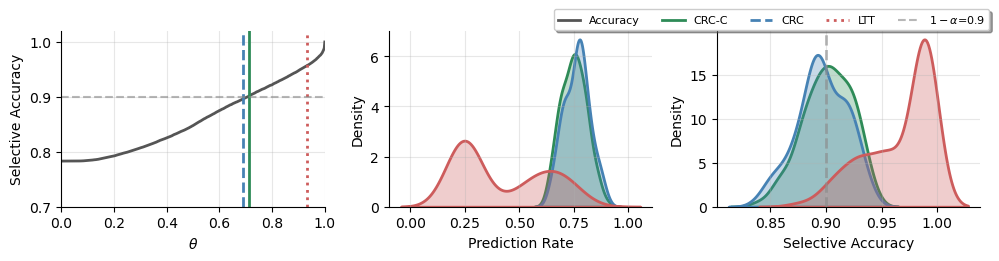

Master figure saved to ./plots/conservative-crc-kde-distributions.pdf


In [7]:
# Master figure for paper
colors = {'crc_c': '#2E8B57', 'crc': '#4682B4', 'ltt': '#CD5C5C'}

# Get representative theta hats (mean across replicates)
theta_crc_c = results_experiment['crc_c_threshold'].mean()
theta_crc = results_experiment['crc_threshold'].mean()
theta_ltt = results_experiment['ltt_threshold'].mean()

# Compute accuracy curve
thetas_viz = np.linspace(0, 1, grid_size)
accuracy_curve = []
for theta in thetas_viz:
    sel = phats >= theta
    if sel.sum() > 0:
        accuracy_curve.append(1-errors[sel].mean())
    else:
        accuracy_curve.append(np.nan)
accuracy_curve = np.array(accuracy_curve)

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(10, 2.5))

# Plot 1 (Left): Accuracy curve with theta hats
ax = axes[0]
ax.plot(thetas_viz, accuracy_curve, linewidth=2, color='#555555', label='Accuracy')
ax.axvline(x=theta_crc_c, linewidth=2, linestyle='-',
           label=f'CRC-C', color=colors['crc_c'])
ax.axvline(x=theta_crc, linewidth=2, linestyle='--',
           label=f'CRC', color=colors['crc'])
ax.axvline(x=theta_ltt, linewidth=2, linestyle=':',
           label=f'LTT', color=colors['ltt'])
ax.axhline(y=1-alpha, linewidth=1.5, linestyle='--',
           label=f'$1-\\alpha$={1-alpha}', color='#888888', alpha=0.6)
ax.set_xlabel('$\\theta$')
ax.set_ylabel('Selective Accuracy')
ax.set_xlim([0, 1])
ax.set_ylim([0.7, 1.02])
ax.grid(True, alpha=0.3)
sns.despine(ax=ax)

# Plot 2 (Middle): KDE of prediction rate
ax = axes[1]
sns.kdeplot(results_experiment['crc_c_pred_rate'], ax=ax, label='CRC-C',
            color=colors['crc_c'], linewidth=2, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['crc_pred_rate'], ax=ax, label='CRC',
            color=colors['crc'], linewidth=2, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['ltt_pred_rate'], ax=ax, label='LTT',
            color=colors['ltt'], linewidth=2, fill=True, alpha=0.3)
ax.set_xlabel('Prediction Rate')
ax.set_ylabel('Density')
ax.grid(True, alpha=0.3)
sns.despine(ax=ax)

# Plot 3 (Right): KDE of selective accuracy
ax = axes[2]
sns.kdeplot(results_experiment['crc_c_accuracy'], ax=ax, label='CRC-C',
            color=colors['crc_c'], linewidth=2, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['crc_accuracy'], ax=ax, label='CRC',
            color=colors['crc'], linewidth=2, fill=True, alpha=0.3)
sns.kdeplot(results_experiment['ltt_accuracy'], ax=ax, label='LTT',
            color=colors['ltt'], linewidth=2, fill=True, alpha=0.3)
ax.axvline(x=1-alpha, linewidth=2, linestyle='--', color='#888888', alpha=0.6)
ax.set_xlabel('Selective Accuracy')
ax.set_ylabel('Density')
ax.grid(True, alpha=0.3)
sns.despine(ax=ax)

# Shared legend at bottom
handles, labels_leg = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_leg, loc='upper right', ncol=5, fontsize=8,
           bbox_to_anchor=(1, 1.05), frameon=True, shadow=True)

plt.tight_layout()
os.makedirs('./plots', exist_ok=True)
plt.savefig('./plots/master-figure-imagenet.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("Master figure saved to ./plots/master-figure-imagenet.pdf")